# How to implement a Variational Autoencoder (VAE)

A variational autoencoder observes data, infers a latent code for it and tries to reconstruct the data from that latent code. In contrast to regular autoencoders, the code of the VAE is **random**. That means that when presented with the same input, the VAE will produce a slightly different code each time. This makes its decoding process more robust, since it has to deal with noisy code.

Another way of looking at a VAE is as a training procedure for a probablistic model. The model is 
$$p(x) = \int p(z)p(x|z) dz$$
where $z$ is the latent code and $x$ is the data. During training we need to infer a posterior over $z$. In the case of a VAE this is done by neural network.

Assuming that the theory of VAEs has already been presented, we now dive straight into implementing them. If you need more background on VAEs, have a look at our [tutorial slides](https://github.com/philschulz/VITutorial/tree/master/modules) and the references therein.

# The Framework

For the purpose of this tutorial we are going to use [mxnet](https://mxnet.incubator.apache.org) which is a scalable deep learning library that has interfaces for several languages, including python. We are going to import and abbreviate it as "mx". We will use mxnet to define computation graph. This is done using the [symbol library](https://mxnet.incubator.apache.org/api/python/symbol.html). When building the VAE, all the methods that you use should be prefixed with `mx.sym`.

In [1]:
import mxnet as mx
import urllib.request
import os, logging, sys
from os.path import join, exists
from abc import ABC
from typing import List, Tuple, Callable
from numpy import genfromtxt

Next, we specify a couple of constants that will help us to load the data.

In [2]:
DEFAULT_LEARNING_RATE = 0.0003

TRAIN_SET = 'train'
VALID_SET = 'valid'
TEST_SET = 'test'
data_names = [TRAIN_SET, VALID_SET, TEST_SET]
test_set = [TEST_SET]
data_dir = join(os.curdir, "binary_mnist")

# change this to mx.gpu(0) if you want to run your code on gpu
ctx = mx.cpu()

Finally, we set up basic logging facilities to print intermediate output.

In [3]:
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s [%(levelname)s]: %(message)s", datefmt="%H:%M:%S")

# The Data

Throughout the tutorial we will use the binarised MNIST data set consisting of images of handwritten digits (0-9). Each pixel has been mapped to either 0 or 1, meaning that pixels are either fully on or off. We use this data set because it allows us to use a rather simple product of Bernoullis as a likelihood. We download the data into a folder called "binary_mnist".

In [4]:
if not exists(data_dir):
    os.mkdir(data_dir)
for data_set in data_names:
    file_name = "binary_mnist.{}".format(data_set)
    goal = join(data_dir, file_name)
    if exists(goal):
        logging.info("Data file {} exists".format(file_name))
    else:
        logging.info("Downloading {}".format(file_name))
        link = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_{}.amat".format(
            data_set)
        urllib.request.urlretrieve(link, goal)
        logging.info("Finished")

10:56:19 [INFO]: Data file binary_mnist.train exists
10:56:19 [INFO]: Data file binary_mnist.valid exists
10:56:19 [INFO]: Data file binary_mnist.test exists


Alright, now we have the data on disk. We will load it later for training and testing. But first, we need to build our VAE.

# Diagonal Gaussian VAE

The most basic VAE model is one where we assume that the latent variable is multiviariate Gaussian. We fix the prior to be standard normal. During inference, we use a multivariate Gaussian variational distribution with diagonal covariance matrix. This means that we are only modelling variance but not covariance (in fact, a k-dimensional Guassian with diagonal covariance has the same density as a product of k independent univariate Gaussians). Geometrically, this variational distribution can only account for spherical but not for eliptical densities. It is thus rather limited in its modelling capabilities. Still, because it uses a neural network under the hood, it is very expressive. 

In this tutorial, we will model the mist binarised digit data set. Each image is encoded as a 784-dimensional vector. We will model each of these vectors as a product of 784 Bernoullis (of course, there are better models but we want to keep it simple). Our likelihood is thus a product of independent Bernoullis. The resulting model is formally specified as 

\begin{align}z \sim \mathcal{N}(0,I) && x_i|z \sim Bernoulli(NN_{\theta}(z))~~~ i \in \{1,2,\ldots, 784\} \ .\end{align}

The variational approximation is given by $$q(z|x) = \mathcal{N}(NN_{\lambda}(x), NN_{\lambda}(x)).$$

Notice that both the Bernoulli likelihood and the Gaussian variational distribution use NNs to compute their parameters. The parameters of the NNs, however, are different ($\theta$ and $\lambda$, respectively).

## Implementation

We will spread our implementation across 3 classes. This design choice is motivated by the desire to make our models as modular as possible. This will later allow us to mix and match different likelihoods and variational distributions.

* **Generator**: This class defines our likelihood. Given a latent value, it will can produce a data sample our assign a density to an existing data point.
* **InferenceNetwork**: This neural network computes the parameters of the variational approximation from a data point.
* **VAE**: This is the variational autoencoder. It combines a Generator and an InferenceNetwork and trains them jointly. Once trained, it can generate random data points or try to reproduce data presented to it.

Below we have specified these classes abstractly. Make sure you understand what each method is supposed to be doing.

In [5]:
class Generator(ABC):
    """
    Generator network.

    :param data_dims: Dimensionality of the generated data.
    :param layer_sizes: Size of each layer in the network.
    :param act_type: The activation after each layer.
    """

    def __init__(self, data_dims: int, layer_sizes: List[int], act_type: str) -> None:
        self.data_dims = data_dims
        self.layer_sizes = layer_sizes
        self.act_type = act_type

    def generate_sample(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Generate a data sample from a latent state.

        :param latent_state: The latent input state.
        :return: A data sample.
        """
        raise NotImplementedError()

    def train(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator from a given latent state.
        
        :param latent_state: The latent input state
        :return: The loss symbol used for training
        """
        raise NotImplementedError()

        
class InferenceNetwork(ABC):
    """
    A network to infer distributions over latent states.

    :param latent_variable_size: The dimensionality of the latent variable.
    :param layer_sizes: Size of each layer in the network.
    :param act_type: The activation after each layer.
    """

    def __init__(self, latent_variable_size: int, layer_sizes: List[int], act_type: str) -> None:
        self.latent_var_size = latent_variable_size
        self.layer_sizes = layer_sizes
        self.act_type = act_type

    def inference(self, data: mx.sym.Symbol) -> Tuple[mx.sym.Symbol, ...]:
        """
        Infer the parameters of the distribution over latent values.

        :param data: A data sample.
        :return: The parameters of the distribution.
        """
        raise NotImplementedError()
        
        
class VAE(ABC):
    """
    A variational autoencoding model (Kingma and Welling, 2013).

    :param generator: A generator network that specifies the likelihood of the model.
    :param inference_net: An inference network that specifies the distribution over latent values.
    """

    def __init__(self, generator: Generator, inference_net: InferenceNetwork) -> None:
        self.generator = generator
        self.inference_net = inference_net

    def train(self, data: mx.sym.Symbol, label: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator and inference network jointly by optimising the ELBO.

        :param data: The training data.
        :param label: Copy of the training data.
        :return: A list of loss symbols.
        """
        raise NotImplementedError()

    def generate_reconstructions(self, data: mx.sym.Symbol, n: int) -> mx.sym.Symbol:
        """
        Generate a number of reconstructions of input data points.

        :param data: The input data.
        :param n: Number of reconstructions per data point.
        :return: The reconstructed data.
        """
        raise NotImplementedError()

    def phantasize(self, n: int) -> mx.sym.Symbol:
        """
        Generate data by randomly sampling from the prior.

        :param n: Number of sampled data points.
        :return: Randomly generated data points.
        """
        raise NotImplementedError()

## Exercise 1
Let us start by implementing the generator. This is pretty much a standard neural network. The main point of this exercise is to get you comfortable with mxnet. Complete all the TODOs below. Before starting, check mxnet's [fully connected layer](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.FullyConnected) and [activation functions](https://mxnet.incubator.apache.org/api/python/symbol.html#mxnet.symbol.Activation).

In [6]:
class ProductOfBernoullisGenerator(Generator):
    """
    A generator that produces binary vectors whose entries are independent Bernoulli draws.

    :param data_dims: Dimensionality of the generated data.
    :param layer_sizes: Size of each layer in the network.
    :param act_type: The activation after each layer.
    """

    def __init__(self, data_dims: int, layer_sizes=List[int], act_type=str) -> None:
        super().__init__(data_dims, layer_sizes, act_type)
        # TODO choose the correct output activation for a Bernoulli variable. This should just be a string.
        self.output_act = "sigmoid"

    def _preactivation(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Computes the pre-activation of the generator, i.e. the hidden state before the final output activation.

        :param latent_state: The input latent state
        :return: The pre-activation before output activation
        """
        prev_out = latent_state
        for i, hidden in enumerate(self.layer_sizes):
            fc_i = mx.sym.FullyConnected(data=prev_out, num_hidden=hidden, name="gen_fc_{}".format(i))
            act_i = mx.sym.Activation(data=fc_i, act_type=self.act_type, name="gen_act_{}".format(i))
            prev_out = act_i

        # The output layer that gives pre_activations for multiple Bernoulli softmax between 0 and 1
        fc_out = mx.sym.FullyConnected(data=prev_out, num_hidden=2 * self.data_dims, name="gen_fc_out")

        return fc_out
    
    def generate_sample(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Generates a data sample by picking producing the maximally likely outcome. The stochasticity in the sampling
        process comes from the latent_state.

        :param latent_state: The input latent state.
        :return: A vector of Bernoulli draws.
        """
        act = mx.sym.Activation(data=self._generate(latent_state=latent_state), act_type=self.output_act,
                                name="gen_act_out")
        out = act > 0.5
        return out

        return out

    def train(self, latent_state=mx.sym.Symbol, label=mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator from a given latent state

        :param latent_state: The input latent state
        :param label: A binary vector (same as input for inference module)
        :return: The loss symbol used for training
        """
        output = mx.sym.Activation(data=self._preactivation(latent_state=latent_state), act_type=self.output_act,
                                   name="output_act")
        return mx.sym.sum(label * mx.sym.log(output) + (1-label) * mx.sym.log(1-output), axis=[1])

## Exercise 2

We now move on to the inference network. Recall that this network will return the parameters of a diagonal Gaussian. Thus, we need to return to vectors of the same size: a mean and a standard deviation vector. (Formally, the parameters of the Gaussian are the variances. However, from the derivation of the Gaussian reparametrisation we know that we
need the standard deviations to generate a Gaussian random variable $z$ as transformation of a standard Gaussian variable $\epsilon$.)

**Hint:** In this exercise you will need to draw a random Gaussian sample (see [here](https://mxnet.incubator.apache.org/api/python/symbol.html#mxnet.symbol.random_normal)). The operator requires are
shape whose first entry is the batch size. The batch size is not known to you during implementation, however.
You can leave it underspecified by choosing $0$ as a value. When you combine the sampling operator with another
operator immediately, mxnet will infer the correct the batch size for you.

In [7]:
class GaussianInferenceNetwork(InferenceNetwork):
    """
    An inference network that predicts the parameters of a diagonal Gaussian and samples from that distribution.

    :param latent_variable_size: The dimensionality of the latent variable.
    :param layer_sizes: Size of each layer in the network.
    :param act_type: The activation after each layer.
    """

    def __init__(self, latent_variable_size: int, layer_sizes: List[int], act_type: str):
        super().__init__(latent_variable_size, layer_sizes, act_type)

    def inference(self, data: mx.sym.Symbol) -> Tuple[mx.sym.Symbol, mx.sym.Symbol]:
        """
        Infer the mean and standard deviation.

        :param data: A data sample.
        :return: The mean and standard deviation.
        """
        # We choose to share the first layer between the networks that compute the standard deviations
        # and means. This is a fairly standard design choice.
        shared_layer = mx.sym.FullyConnected(data=data, num_hidden=self.layer_sizes[0], name="inf_joint_fc")
        shared_layer = mx.sym.Activation(data=shared_layer, act_type=self.act_type, name="inf_joint_act")

        prev_out = shared_layer
        for i, size in enumerate(self.layer_sizes[1:]):
            mean_fc_i = mx.sym.FullyConnected(data=prev_out, num_hidden=size, name="inf_mean_fc_{}".format(i))
            mean_act_i = mx.sym.Activation(data=mean_fc_i, act_type=self.act_type, name="inf_mean_act_{}".format(i))
            prev_out = mean_act_i
        mean = mx.sym.FullyConnected(data=prev_out, num_hidden=self.latent_var_size, name="inf_mean_compute")

        prev_out = shared_layer
        for i, size in enumerate(self.layer_sizes[1:]):
            var_fc_i = mx.sym.FullyConnected(data=prev_out, num_hidden=size, name="rec_var_fc_{}".format(i))
            var_act_i = mx.sym.Activation(data=var_fc_i, act_type=self.act_type, name="rec_var_act_{}".format(i))
            prev_out = var_act_i
        # soft-relu maps std onto non-negative real line
        std = mx.sym.Activation(
            mx.sym.FullyConnected(data=prev_out, num_hidden=self.latent_var_size, name="inf_var_compute"),
            act_type="softrelu")

        return mean, std

    def sample_latent_state(self, mean: mx.sym.Symbol, std: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Sample a latent Gaussian variable

        :param mean: The mean of the Gaussian
        :param std: The standard deviation of the Gaussian
        :return: A Gaussian sample
        """
        # TODO: This is where the magic happens! Draw a sample from the Gaussian using the Gaussian reparametrisation
        # trick and return it.
        return mean + std * mx.sym.random_normal(loc=0, scale=1, shape=(0, self.latent_var_size))


# Exercise 3.a

Finally, we will put it all together and build our VAE. Recall that the objective for the inference net contains a KL term. You will need to implement that KL-term. Once it is implemented, we can take advantage of autograd to get its gradients. Use the [log](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.log) and [sum](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.sum) symbols here.

In [8]:
def diagonal_gaussian_kl(mean: mx.sym.Symbol, std: mx.sym.Symbol) -> mx.sym.Symbol:
    var = std ** 2
    return -0.5 * mx.sym.sum(data=1 + mx.sym.log(var) - mean ** 2 - var, axis=1)

# Exercise 3.b

The only thing that is left to do is to implement VAE training. To train our VAE we will maximise the ELBO:
$$ \mathbb{E}\left[ \log p(x|z) \right] - \text{KL}(q(z)||p(z) \. $$
Recall that we assume that $ p(z) = \mathcal{N}(z;0,I) $. Mxnet's optimisers minimise losses instead of maximising objectives. We thus turn the ELBO into a loss by taking its negative. Losses in mxnet are defined using the [MakeLoss](https://mxnet.incubator.apache.org/api/python/symbol.html#mxnet.symbol.MakeLoss) symbol.

In [9]:
class GaussianVAE(VAE):
    """
    A VAE with Gaussian latent variables. It assumes a standard normal prior on the latent values.

    :param generator: A generator network that specifies the likelihood of the model.
    :param inference_net: An inference network that specifies the Gaussian over latent values.
    """

    def __init__(self,
                 generator: Generator,
                 inference_net: GaussianInferenceNetwork,
                 kl_divergence: Callable) -> None:
        self.generator = generator
        self.inference_net = inference_net
        self.kl_divergence = kl_divergence

    def train(self, data: mx.sym.Symbol, label: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator and inference network jointly by optimising the ELBO.

        :param data: The training data.
        :param label: Copy of the training data.
        :return: A list of loss symbols.
        """
        mean, std = self.inference_net.inference(data=data)
        latent_state = self.inference_net.sample_latent_state(mean, std)
        kl_term = self.kl_divergence(mean, std)
        log_likelihood = self.generator.train(latent_state=latent_state, label=label)
        return mx.sym.MakeLoss(kl_term - log_likelihood)

    def generate_reconstructions(self, data: mx.sym.Symbol, n: int) -> mx.sym.Symbol:
        """
        Generate a number of reconstructions of input data points.

        :param data: The input data.
        :param n: Number of reconstructions per data point.
        :return: The reconstructed data.
        """
        mean, std = self.inference_net.inference(data=data)
        mean = mx.sym.tile(data=mean, reps=(n, 1))
        std = mx.sym.tile(data=std, reps=(n, 1))
        latent_state = self.sample_latent_state(mean, std, n)
        return self.generator.generate_sample(latent_state=latent_state)

    def phantasize(self, n: int) -> mx.sym.Symbol:
        """
        Generate data by randomly sampling from the prior.

        :param n: Number of sampled data points.
        :return: Randomly generated data points.
        """
        latent_state = mx.sym.random_normal(loc=0, scale=1, shape=(n, self.inference_net.latent_var_size))
        return self.generator.generate_sample(latent_state=latent_state)

# Constructing a VAE

We have now all the code for VAEs in place. Below, we have defined a factory method that makes it easier for you to play with different architectures.

In [10]:
def construct_vae(latent_type: str,
                  likelihood: str,
                  generator_layer_sizes: List[int],
                  infer_layer_sizes: List[int],
                  latent_variable_size: int,
                  data_dims: int,
                  generator_act_type: str = "tanh",
                  infer_act_type: str = "tanh") -> VAE:
    """
    Construct a variational autoencoder

    :param latent_type: Distribution of latent variable.
    :param likelihood: Type of likelihood.
    :param generator_layer_sizes: Sizes of generator hidden layers.
    :param infer_layer_size: Sizes of inference network hidden layers.
    :param latent_variable_size: Size of the latent variable.
    :param data_dims: Dimensionality of the data.
    :param generator_act_type: Activation function for generator hidden layers.
    :param infer_act_type: Activation function for inference network hidden layers.
    :return: A variational autoencoder.
    """
    if likelihood == "bernoulliProd":
        generator = ProductOfBernoullisGenerator(data_dims=data_dims, layer_sizes=generator_layer_sizes,
                                                 act_type=generator_act_type)
    else:
        raise Exception("{} is an invalid likelihood type.".format(likelihood))

    if latent_type == "gaussian":
        inference_net = GaussianInferenceNetwork(latent_variable_size=latent_variable_size,
                                                 layer_sizes=infer_layer_sizes,
                                                 act_type=infer_act_type)
        return GaussianVAE(generator=generator, inference_net=inference_net, kl_divergence=diagonal_gaussian_kl)
    else:
        raise Exception("{} is an invalid latent variable type.".format(latent_type))


# Exercise 4

Your turn! Construct your own VAE below.

In [11]:
vae = construct_vae(latent_type="gaussian", likelihood="bernoulliProd", generator_layer_sizes=[200,500],
                   infer_layer_sizes=[500,200], latent_variable_size=200, data_dims=784, generator_act_type="tanh",
                   infer_act_type="tanh")

To check what your VAE looks like we will visualise it. The variables are "data" and "label" are unbound variables in the computation graph. We will shortly use them to supply data to the model.

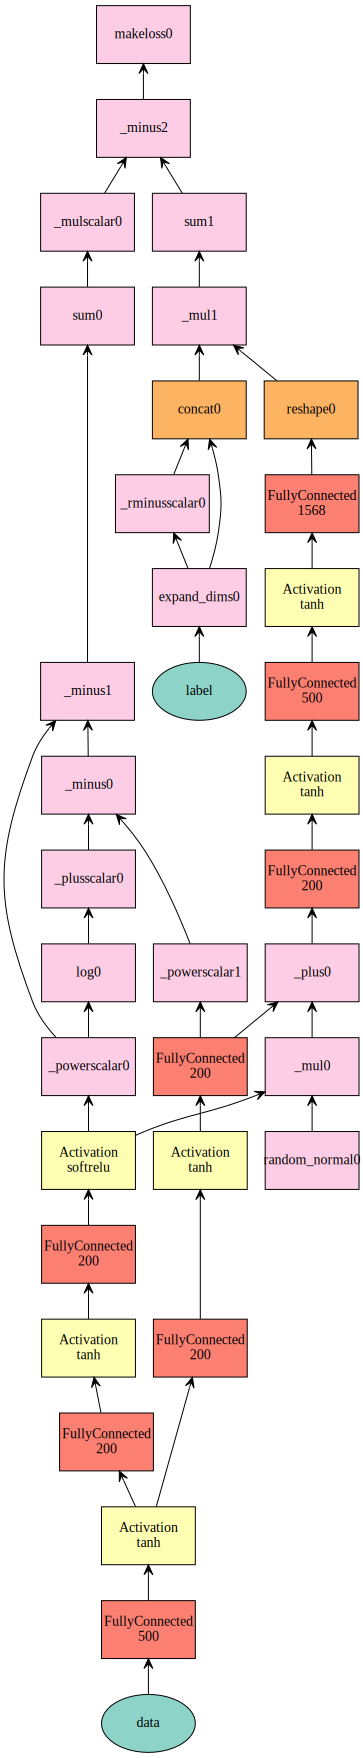

In [12]:
data = mx.sym.Variable("data")
label = mx.sym.Variable("label")
mx.viz.plot_network(vae.train(data, label))
# Comment the line above and uncomment the one below if you want to save the VAE picture on disk
#mx.viz.plot_network(vae.train(data, label), title="my_vae", save_format="pdf")

# Training a VAE

We are now set to train the VAE. In order to do so we have to define a data iterator and a module in mxnet. The data iterator takes care of batching the data while the module executes the computation graph and updates the model parameters. For the purpose of training the model, we only need the training data which we load from disk.

In [13]:
mnist = {}
file_name = join(data_dir, "binary_mnist.{}".format(TRAIN_SET))
logging.info("Reading {} into memory".format(file_name))
mnist[TRAIN_SET] = mx.nd.array(genfromtxt(file_name))
logging.info("{} contains {} data points".format(file_name, mnist[TRAIN_SET].shape[0]))

10:58:18 [INFO]: Reading ./binary_mnist/binary_mnist.train into memory
10:58:51 [INFO]: ./binary_mnist/binary_mnist.train contains 50000 data points


Using that data we define the training set iterator. At this point we also need to choose a batch_size that will then be used in training. Notice that we randomise the order in which the data points are presented in the training set. It is important that `data_name` and `label_name` match the names of the unbound variables in our model. Mxnet will use this information to pass the correct data points to the variables. Finally, notice that the data and labels are identical. This is because the VAE tries to reconstruct its input data and thus labels and data are the same.

In [14]:
batch_size = 100
train_iter = mx.io.NDArrayIter(data=mnist[TRAIN_SET], data_name="data", label=mnist[TRAIN_SET], label_name="label",
                                   batch_size=batch_size, shuffle=True)

Now we can define a module that will do the training for us.

In [1]:
vae_module = mx.module.Module(vae.train(data=mx.sym.Variable("data"), label=mx.sym.Variable("label")),
                           data_names=[train_iter.provide_data[0][0]],
                           label_names=[train_iter.provide_label[0][0]], context=ctx, logger=logging)

NameError: name 'mx' is not defined

Training the vae (or any other network defined in mxnet) is most easily done using the fit method. Here we choose to train our model for 20 epochs. Our optimiser will be adam. Training will take some time (2-5 minutes depending on your machine). We are keeping track of the loss (the negative ELBO) to see how the model develops. Notice that this loss
is not the actual negative ELBO but a _doubly stochastic approximation_ to it (see [here](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586) and [here](http://proceedings.mlr.press/v32/titsias14.pdf)). The two sources of stochasticity are the mini-batches (the ELBO is defined with respect to the entire data set) and the reparametrisation trick (we approximate the integral over $ z $ through sampling). Both sources of stochasticity leave the approximation unbiased, however. 

In [ ]:
epochs = 20
optimiser = "adam"

vae_module.fit(train_data=train_iter, optimizer=optimiser, force_init=True, force_rebind=True, num_epoch=epochs,
               optimizer_params={'learning_rate': DEFAULT_LEARNING_RATE},
               batch_end_callback=mx.callback.Speedometer(frequent=20, batch_size=batch_size),
               epoch_end_callback=mx.callback.do_checkpoint('vae'),
               eval_metric="Loss")